In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary, mcnemar
import torch

In [2]:
filepath = 'dataset/glass.csv'
df = pd.read_csv(filepath)

In [3]:
data = np.array(df.values)
X = data[:, :-1].copy()
X = np.array(X, dtype=np.float64)
# Getting the classes to be in the format 0, 1
y = data[:, -1] - 1
print(X.shape)
print(X[0])
# Dropping the last two columns since they are mostly 0
X = X[:,:-2]
N = X.shape[0]  # Number of samples
M = X.shape[1]  # Number of attributes per sample
print(X.shape)
N, M

(163, 9)
[1.52101e+00 1.36400e+01 4.49000e+00 1.10000e+00 7.17800e+01 6.00000e-02
 8.75000e+00 0.00000e+00 0.00000e+00]
(163, 7)


(163, 7)

In [98]:
# Creating the baseline model (classifies everything as the most common class)
# This is just for TESTING
class_1 = np.count_nonzero(y)
class_0 = N - class_1
baseline = np.argmax([class_0, class_1])
# always prediting class 0
print(baseline)

K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)
errors_baseline = np.zeros((K))
i = 0

for train_index, test_index in CV.split(X, y):
    print('Crossvalidation fold: {0}/{1}'.format(i+1,K))

    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    y_est_baseline = baseline*np.ones(y_test.shape)
    errors_baseline[i] = np.sum(y_est_baseline!=y_test)/len(y_test)
    i+=1
print(errors_baseline)

0
Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10
[0.70588235 0.52941176 0.35294118 0.3125     0.375      0.5625
 0.4375     0.375      0.4375     0.5625    ]


In [106]:
# Ex 3
# L = max no of neighbours
L = 40
# K = outer cross validation folds
K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)
# L2 regularization parameter for logistic regression
lambda_interval = np.logspace(-8, 2, 50)
# Errors for logistic regression
train_error_rate_LR = np.zeros((K, len(lambda_interval)))
test_error_rate_LR = np.zeros((K, len(lambda_interval)))
coefficient_norm_LR = np.zeros((K, len(lambda_interval)))
# Errors for baseline
errors_baseline = np.zeros(K)
# Errors for KNN
errors_knn = np.zeros((K, L))


i = 0
for train_index, test_index in CV.split(X, y):
    print('Crossvalidation fold: {0}/{1}'.format(i+1,K))

    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Baseline predictions
    y_est_baseline = baseline*np.ones(y_test.shape)
    errors_baseline[i] = np.sum(y_est_baseline!=y_test)/len(y_test)

    # Inner CV for logistic regression
    for k in range(0, len(lambda_interval)):
        mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k])

        mdl.fit(X_train, y_train)

        y_train_est = mdl.predict(X_train).T
        y_test_est = mdl.predict(X_test).T

        train_error_rate_LR[i, k] = np.sum(y_train_est != y_train) / len(y_train)
        test_error_rate_LR[i, k] = np.sum(y_test_est != y_test) / len(y_test)

        w_est = mdl.coef_[0]
        coefficient_norm_LR[i, k] = np.sqrt(np.sum(w_est ** 2))

    # Inner CV for KNN from 1 to 40 neighbours
    for l in range(1,L+1):
        knclassifier = KNeighborsClassifier(n_neighbors=l)
        knclassifier.fit(X_train, y_train)
        y_est = knclassifier.predict(X_test)
        errors_knn[i, l - 1] = np.sum(y_est != y_test) / len(y_test)
    i += 1

print(errors_baseline)

for i in range(K):
    print(f'The minimum error of split {i+1} is: e = {min(test_error_rate_LR[i])} model uses '
          f'lambda = {lambda_interval[np.argmin(test_error_rate_LR[i])]}')

print(f'The minimum error averaged over the 10 splits is: e = {min(100 * sum(test_error_rate_LR, 0) / K)} for a model '
      f'with lambda =  {lambda_interval[np.argmin(100 * sum(test_error_rate_LR, 0) / K)]}, ')

for i in range(K):
    print(f'The minimum error of split {i+1} is: e = {min(errors_knn[i])} model uses {np.argmin(errors_knn[i]) + 1} neighbours')

print(f'The minimum error averaged over the 10 splits is: e = {min(100 * sum(errors_knn, 0) / K)} for a model with {np.argmin(100 * sum(errors_knn, 0) / K) + 1}')

Crossvalidation fold: 1/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 2/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 3/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 4/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 5/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 6/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 7/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 8/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 9/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 10/10


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[0.41176471 0.47058824 0.41176471 0.4375     0.4375     0.4375
 0.1875     0.75       0.5625     0.5625    ]
The minimum error of split 1 is: e = 0.23529411764705882 model uses lambda = 1e-08
The minimum error of split 2 is: e = 0.35294117647058826 model uses lambda = 1.5998587196060573e-08
The minimum error of split 3 is: e = 0.11764705882352941 model uses lambda = 1.4563484775012443
The minimum error of split 4 is: e = 0.0625 model uses lambda = 2.329951810515372
The minimum error of split 5 is: e = 0.125 model uses lambda = 2.329951810515372
The minimum error of split 6 is: e = 0.1875 model uses lambda = 1e-08
The minimum error of split 7 is: e = 0.125 model uses lambda = 62.50551925273976
The minimum error of split 8 is: e = 0.5 model uses lambda = 4.0949150623804276e-08
The minimum error of split 9 is: e = 0.3125 model uses lambda = 0.13894954943731389
The minimum error of split 10 is: e = 0.125 model uses lambda = 1.4563484775012443
The minimum error averaged over the 10 splits i

C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10
The minimum error of split 0 is: e = 0.17647058823529413 model uses 1 neighbours
The minimum error of split 1 is: e = 0.11764705882352941 model uses 1 neighbours
The minimum error of split 2 is: e = 0.17647058823529413 model uses 4 neighbours
The minimum error of split 3 is: e = 0.0625 model uses 2 neighbours
The minimum error of split 4 is: e = 0.125 model uses 1 neighbours
The minimum error of split 5 is: e = 0.0625 model uses 40 neighbours
The minimum error of split 6 is: e = 0.125 model uses 1 neighbours
The minimum error of split 7 is: e = 0.125 model uses 1 neighbours
The minimum error of split 8 is: e = 0.1875 model uses 1 neighbours
The minimum error of split 9 is: e = 0.0 model uses 4 neighbours
The minimum err

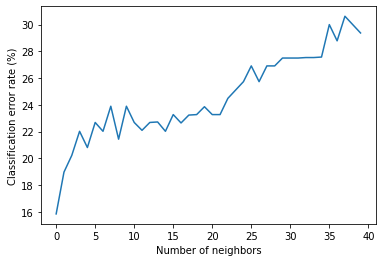

In [103]:
# TESTING
# Method 2 is KNN
# Maximum number of neighbors
L = 40
K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)  # .LeaveOneOut()
errors_knn = np.zeros((K, L))
i = 0
for train_index, test_index in CV.split(X, y):
    print('Crossvalidation fold: {0}/{1}'.format(i+1,K))

    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Fit classifier and classify the test points (consider 1 to 40 neighbors)
    for l in range(1,L+1):
        knclassifier = KNeighborsClassifier(n_neighbors=l)
        knclassifier.fit(X_train, y_train)
        y_est = knclassifier.predict(X_test)
        errors_knn[i, l - 1] = np.sum(y_est != y_test) / len(y_test)

    i+=1

for i in range(K):
    print(f'The minimum error of split {i} is: e = {min(errors_knn[i])} model uses {np.argmin(errors_knn[i]) + 1} neighbours')

print(f'The minimum error averaged over the 10 splits is: e = {min(100 * sum(errors_knn, 0) / K)} for a model with {np.argmin(100 * sum(errors_knn, 0) / K) + 1}')

# Plot the classification error rate
plt.figure()
plt.plot(100 * sum(errors_knn, 0) / K)
plt.xlabel('Number of neighbors')
plt.ylabel('Classification error rate (%)')
plt.show()

In [112]:
# Ex 4 McNemar's test
# Using the optimal hyperparameters for LR and KNN, lambda = 0.91, K = 1
CV = model_selection.LeaveOneOut()
i = 0
yhat = []
y_true = []
# optimal no of neighbours obtained at ex 3
K_nn = 1
# optimal lambda
lambd = 0.91

for train_index, test_index in CV.split(X, y):
    print('Crossvalidation fold: {0}/{1}'.format(i+1,N))

    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    dy = []

    # Baseline predictions
    y_est_baseline = baseline*np.ones(y_test.shape)
    dy.append(y_est_baseline)

    # Logistic Regression
    mdl = LogisticRegression(penalty='l2', C=1/lambd)
    mdl.fit(X_train, y_train)
    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T
    dy.append(y_test_est)

    # KNN
    knclassifier = KNeighborsClassifier(n_neighbors=K_nn)
    knclassifier.fit(X_train, y_train)
    y_est = knclassifier.predict(X_test)
    dy.append(y_est)

    dy = np.stack(dy, axis=1)
    yhat.append(dy)
    y_true.append(y_test)

    i += 1

yhat = np.concatenate(yhat)
y_true = np.concatenate(y_true)
accuracies = [0, 0, 0]
for i in range(len(accuracies)):
    accuracies[i] = np.sum(yhat[:, i] == y_true)/float(len(y_true))

print(accuracies)


Crossvalidation fold: 1/163
Crossvalidation fold: 2/163
Crossvalidation fold: 3/163
Crossvalidation fold: 4/163
Crossvalidation fold: 5/163
Crossvalidation fold: 6/163
Crossvalidation fold: 7/163
Crossvalidation fold: 8/163
Crossvalidation fold: 9/163
Crossvalidation fold: 10/163
Crossvalidation fold: 11/163
Crossvalidation fold: 12/163
Crossvalidation fold: 13/163
Crossvalidation fold: 14/163
Crossvalidation fold: 15/163
Crossvalidation fold: 16/163
Crossvalidation fold: 17/163
Crossvalidation fold: 18/163
Crossvalidation fold: 19/163
Crossvalidation fold: 20/163
Crossvalidation fold: 21/163
Crossvalidation fold: 22/163
Crossvalidation fold: 23/163
Crossvalidation fold: 24/163
Crossvalidation fold: 25/163
Crossvalidation fold: 26/163
Crossvalidation fold: 27/163
Crossvalidation fold: 28/163
Crossvalidation fold: 29/163
Crossvalidation fold: 30/163
Crossvalidation fold: 31/163
Crossvalidation fold: 32/163
Crossvalidation fold: 33/163
Crossvalidation fold: 34/163
Crossvalidation fold: 3

C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 39/163
Crossvalidation fold: 40/163
Crossvalidation fold: 41/163
Crossvalidation fold: 42/163
Crossvalidation fold: 43/163
Crossvalidation fold: 44/163
Crossvalidation fold: 45/163
Crossvalidation fold: 46/163
Crossvalidation fold: 47/163
Crossvalidation fold: 48/163
Crossvalidation fold: 49/163
Crossvalidation fold: 50/163
Crossvalidation fold: 51/163
Crossvalidation fold: 52/163
Crossvalidation fold: 53/163
Crossvalidation fold: 54/163
Crossvalidation fold: 55/163
Crossvalidation fold: 56/163
Crossvalidation fold: 57/163
Crossvalidation fold: 58/163
Crossvalidation fold: 59/163
Crossvalidation fold: 60/163
Crossvalidation fold: 61/163
Crossvalidation fold: 62/163
Crossvalidation fold: 63/163
Crossvalidation fold: 64/163
Crossvalidation fold: 65/163
Crossvalidation fold: 66/163
Crossvalidation fold: 67/163
Crossvalidation fold: 68/163
Crossvalidation fold: 69/163
Crossvalidation fold: 70/163
Crossvalidation fold: 71/163
Crossvalidation fold: 72/163
Crossvalidatio

C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 81/163
Crossvalidation fold: 82/163
Crossvalidation fold: 83/163
Crossvalidation fold: 84/163
Crossvalidation fold: 85/163
Crossvalidation fold: 86/163
Crossvalidation fold: 87/163
Crossvalidation fold: 88/163
Crossvalidation fold: 89/163
Crossvalidation fold: 90/163
Crossvalidation fold: 91/163
Crossvalidation fold: 92/163
Crossvalidation fold: 93/163
Crossvalidation fold: 94/163
Crossvalidation fold: 95/163
Crossvalidation fold: 96/163
Crossvalidation fold: 97/163
Crossvalidation fold: 98/163
Crossvalidation fold: 99/163
Crossvalidation fold: 100/163
Crossvalidation fold: 101/163
Crossvalidation fold: 102/163
Crossvalidation fold: 103/163
Crossvalidation fold: 104/163
Crossvalidation fold: 105/163
Crossvalidation fold: 106/163
Crossvalidation fold: 107/163
Crossvalidation fold: 108/163
Crossvalidation fold: 109/163
Crossvalidation fold: 110/163
Crossvalidation fold: 111/163
Crossvalidation fold: 112/163
Crossvalidation fold: 113/163
Crossvalidation fold: 114/163

C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Crossvalidation fold: 119/163
Crossvalidation fold: 120/163
Crossvalidation fold: 121/163
Crossvalidation fold: 122/163
Crossvalidation fold: 123/163
Crossvalidation fold: 124/163
Crossvalidation fold: 125/163
Crossvalidation fold: 126/163
Crossvalidation fold: 127/163
Crossvalidation fold: 128/163
Crossvalidation fold: 129/163
Crossvalidation fold: 130/163
Crossvalidation fold: 131/163
Crossvalidation fold: 132/163
Crossvalidation fold: 133/163
Crossvalidation fold: 134/163
Crossvalidation fold: 135/163
Crossvalidation fold: 136/163
Crossvalidation fold: 137/163
Crossvalidation fold: 138/163
Crossvalidation fold: 139/163
Crossvalidation fold: 140/163
Crossvalidation fold: 141/163
Crossvalidation fold: 142/163
Crossvalidation fold: 143/163
Crossvalidation fold: 144/163
Crossvalidation fold: 145/163
Crossvalidation fold: 146/163
Crossvalidation fold: 147/163
Crossvalidation fold: 148/163
Crossvalidation fold: 149/163
Crossvalidation fold: 150/163
Crossvalidation fold: 151/163
Crossvalid

C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [115]:
# Statistical testing Baseline vs LR
alpha = 0.05
[thetahat, CI, p] = mcnemar(y_true, yhat[:, 1], yhat[:, 0], alpha=alpha)
print(f'For baseline and LR p-value = {p}')
print(f'For baseline and LR CI = [{CI[0]}, {CI[1]}]')

# Statistical testing Baseline vs KNN
alpha = 0.05
[thetahat, CI, p] = mcnemar(y_true, yhat[:, 2], yhat[:, 0], alpha=alpha)
print(f'For baseline and KNN p-value = {p}')
print(f'For baseline and KNN CI = [{CI[0]}, {CI[1]}]')

# Statistical testing LR vs KNN
alpha = 0.05
[thetahat, CI, p] = mcnemar(y_true, yhat[:, 2], yhat[:, 1], alpha=alpha)
print(f'For LR and KNN p-value = {p}')
print(f'For LR and KNN CI = [{CI[0]}, {CI[1]}]')

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[70. 51.]
 [17. 25.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.11414063750155856, 0.30115009243487734)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 4.453448771493584e-05
For baseline and LR p-value = 4.453448771493584e-05
For baseline and LR CI = [0.11414063750155856, 0.30115009243487734]
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[77. 59.]
 [10. 17.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.21107783240664268, 0.38760146000261075)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 1.3765197153783534e-09
For baseline and KNN p-value = 1.3765197153783534e-09
For baseline and KNN CI = [0.21107783240664268, 0.38760146000261075]
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[109.  27.]
 [ 12.  15.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  

C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Weights for the simple LR model: [ 0.08871975  0.39718627 -1.27881053  1.44759371 -0.0297487   0.80745297
 -0.25925943]
Weights' L2 norm: 2.1486257848406245
Model Error: 0.2653061224489796


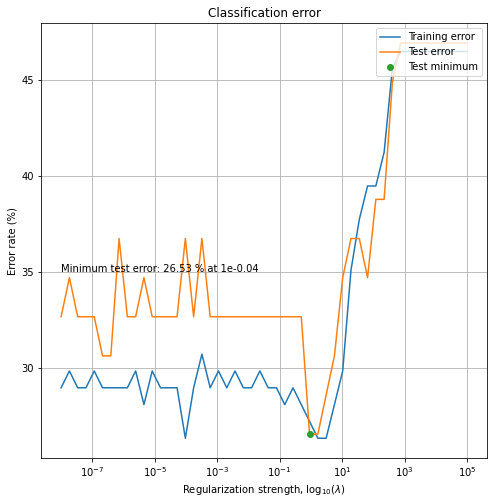

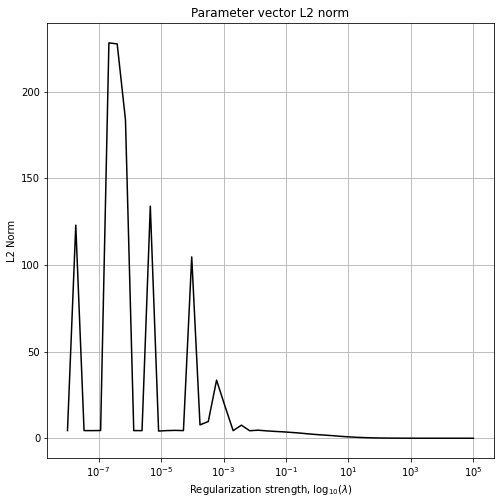

In [28]:
# Ex 5
# Create crossvalidation partition for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# Fit regularized logistic regression model to training data to predict
# the type of glass
lambda_interval = np.logspace(-8, 5, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
w = []
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k])

    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0]
    w.append(w_est)
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]
norm_coeff_opt = coefficient_norm[opt_lambda_idx]
w_opt = w[opt_lambda_idx]
print(f'Weights for the simple LR model: {w_opt}')
print(f"Weights' L2 norm: {norm_coeff_opt}")
print(f'Model Error: {min_error}')

plt.figure(figsize=(8,8))
#plt.plot(np.log10(lambda_interval), train_error_rate*100)
#plt.plot(np.log10(lambda_interval), test_error_rate*100)
#plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate*100)
plt.semilogx(lambda_interval, test_error_rate*100)
plt.semilogx(opt_lambda, min_error*100, 'o')
plt.text(1e-8, 35, "Minimum test error: " + str(np.round(min_error*100,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.ylabel('Error rate (%)')
plt.title('Classification error')
plt.legend(['Training error','Test error','Test minimum'],loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(8,8))
plt.semilogx(lambda_interval, coefficient_norm,'k')
plt.ylabel('L2 Norm')
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.title('Parameter vector L2 norm')
plt.grid()
plt.show()


C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Florin Mazilu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Weights for the simple LR model: [ 0.04567774  0.3667128  -1.26031974  1.38350591 -0.02403694  0.60757782
 -0.26784023]
Weights' L2 norm: 2.0200312282131683
Model Error: 0.24489795918367346


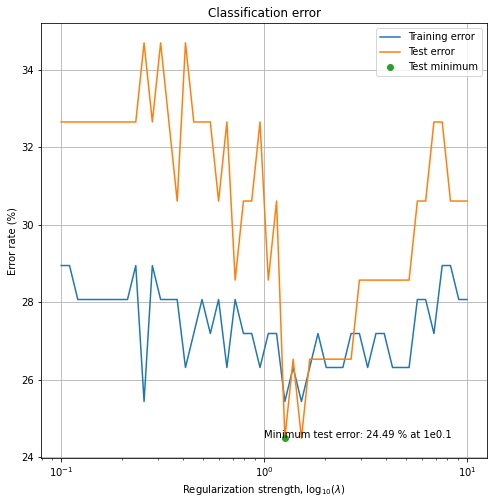

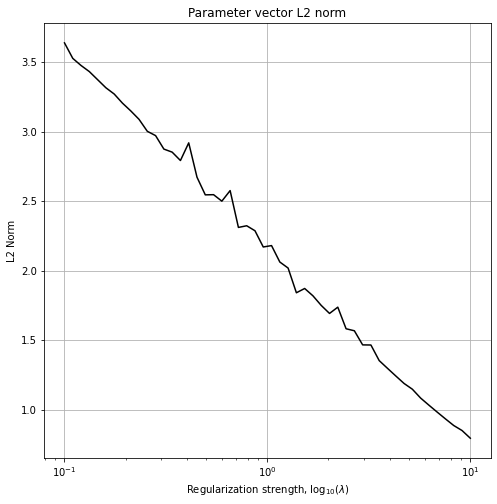

In [32]:
# Create crossvalidation partition for evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, stratify=y)

# Fit regularized logistic regression model to training data to predict
# the type of glass
lambda_interval = np.logspace(-1, 1, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
w = []
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k])

    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0]
    w.append(w_est)
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]
norm_coeff_opt = coefficient_norm[opt_lambda_idx]
w_opt = w[opt_lambda_idx]
print(f'Weights for the simple LR model: {w_opt}')
print(f"Weights' L2 norm: {norm_coeff_opt}")
print(f'Model Error: {min_error}')

plt.figure(figsize=(8,8))
#plt.plot(np.log10(lambda_interval), train_error_rate*100)
#plt.plot(np.log10(lambda_interval), test_error_rate*100)
#plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate*100)
plt.semilogx(lambda_interval, test_error_rate*100)
plt.semilogx(opt_lambda, min_error*100, 'o')
plt.text(1e-0, min_error*100, "Minimum test error: " + str(np.round(min_error*100,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.ylabel('Error rate (%)')
plt.title('Classification error')
plt.legend(['Training error','Test error','Test minimum'],loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(8,8))
plt.semilogx(lambda_interval, coefficient_norm,'k')
plt.ylabel('L2 Norm')
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.title('Parameter vector L2 norm')
plt.grid()
plt.show()


In [30]:
# Simple Logistic Regression model
mdl1 = LogisticRegression()

mdl1.fit(X_train, y_train)

y_train_est = mdl1.predict(X_train).T
y_test_est = mdl1.predict(X_test).T

train_error_rate1 = np.sum(y_train_est != y_train) / len(y_train)
test_error_rate1 = np.sum(y_test_est != y_test) / len(y_test)

w_est1 = mdl1.coef_[0]
coefficient_norm1 = np.sqrt(np.sum(w_est1**2))
print(f'Weights for the simple LR model: {w_est1}')
print(f"Weights' L2 norm: {coefficient_norm1}")
print(f'Model Error: {test_error_rate1}')

Weights for the simple LR model: [ 0.03435294  0.39460158 -1.29348123  1.45762288 -0.01572187  0.78756536
 -0.25252306]
Weights' L2 norm: 2.1538159066011704
Model Error: 0.2653061224489796


Computing CV fold: 1/7..
Computing CV fold: 2/7..
Computing CV fold: 3/7..
Computing CV fold: 4/7..
Computing CV fold: 5/7..
Computing CV fold: 6/7..
Computing CV fold: 7/7..


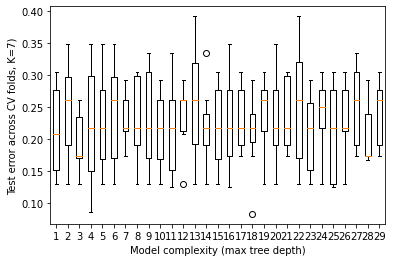

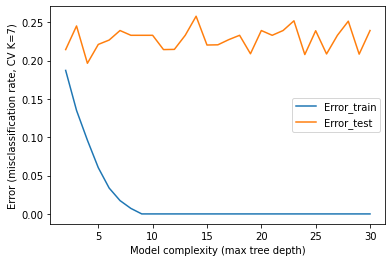

In [65]:
# Decision tree
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, boxplot
from sklearn import model_selection, tree
import numpy as np

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 31, 1)

# K-fold crossvalidation
K = 7
CV = model_selection.KFold(n_splits=K, shuffle=True)

# Initialize variable
Error_train = np.empty((len(tc), K))
Error_test = np.empty((len(tc), K))

k = 0
for train_index, test_index in CV.split(X):
    print('Computing CV fold: {0}/{1}..'.format(k + 1, K))

    # extract training and test set for current CV fold
    X_train, y_train = X[train_index, :], y[train_index]
    X_test, y_test = X[test_index, :], y[test_index]

    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
        dtc = dtc.fit(X_train, y_train.ravel())
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        # Evaluate misclassification rate over train/test data (in this CV fold)
        misclass_rate_test = np.sum(y_est_test != y_test) / float(len(y_est_test))
        misclass_rate_train = np.sum(y_est_train != y_train) / float(len(y_est_train))
        Error_test[i, k], Error_train[i, k] = misclass_rate_test, misclass_rate_train
    k += 1

plt.figure()
plt.boxplot(Error_test.T)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Test error across CV folds, K={0})'.format(K))

plt.figure()
plt.plot(tc, Error_train.mean(1))
plt.plot(tc, Error_test.mean(1))
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(K))
plt.legend(['Error_train', 'Error_test'])

plt.show()

Training model of type:
Sequential(
  (0): Linear(in_features=7, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): Tanh()
  (4): Linear(in_features=5, out_features=1, bias=True)
  (5): Sigmoid()
)


Crossvalidation fold: 1/5

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.54925907	5.4581713e-05
		Final loss:
		1229	0.54378694	7.6727144e-07

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.42680266	0.00014144936
		Final loss:
		1812	0.40117723	8.1715825e-07

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.55480945	8.336078e-05
		Final loss:
		1313	0.5449559	3.2812562e-07

	Best loss: 0.40117722749710083


Crossvalidation fold: 2/5

	Replicate: 1/3
		Iter	Loss			Rel. loss
		Final loss:
		10	0.68733907	3.4687199e-07

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.46343574	0.00032181898
		Final loss:
		1652	0.38359833	6.2153146e-07

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.4166121	0.00026439477
		2000	0.37781373	2.658219e

<Figure size 720x720 with 0 Axes>

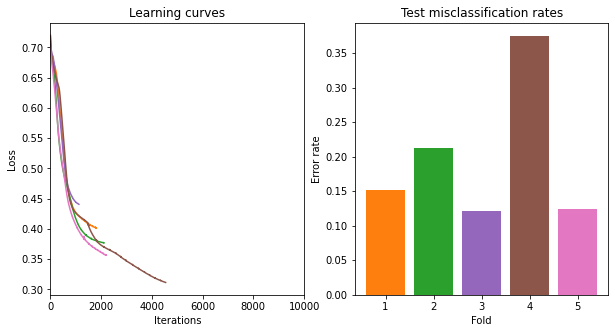

Diagram of best neural net in last fold:


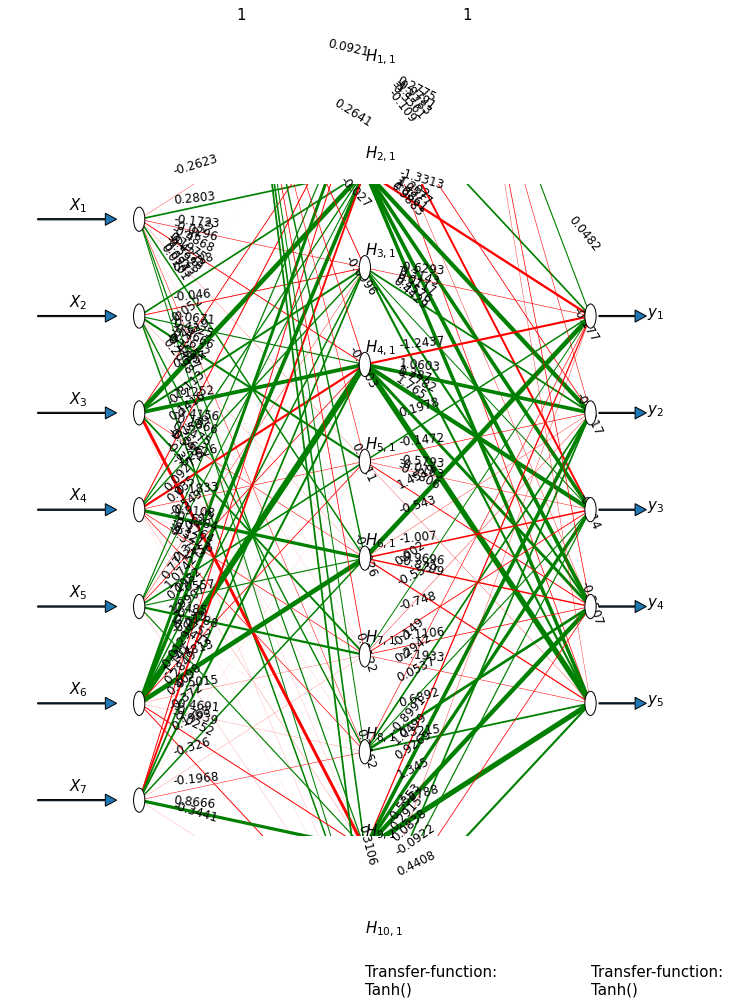


Generalization error/average error rate: 19.697%


In [66]:
# Trying ANN
# K-fold CrossValidation (4 folds here to speed up this example)
K = 5
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10,10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K)))
subplot_size_2 = int(np.ceil(K/subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle('Data and model decision boundaries', fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model structure
n_hidden_units_1 = 10  # number of hidden units in the signle hidden layer
n_hidden_units_2 = 5
# The lambda-syntax defines an anonymous function, which is used here to
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units_1), #M features to H hiden units
    # 1st transfer function, either Tanh or ReLU:
    torch.nn.Tanh(),                            #torch.nn.ReLU(),
    torch.nn.Linear(n_hidden_units_1,n_hidden_units_2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden_units_2, 1), # H hidden units to 1 output neuron
    torch.nn.Sigmoid()  # final tranfer function
)
# Since we're training a neural network for binary classification, we use a
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))
y_ann = np.reshape(y, (y.shape[0],1))
# Do cross-validation:
errors_knn = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the
# indices to be used for training and testing in each split, and calling
# the enumerate-method with this simply returns this indices along with
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X,y)):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))

    # Extract training and test set for current CV fold,
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y_ann[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y_ann[test_index])

    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3,
                                                       max_iter=max_iter)

    print('\n\tBest loss: {}\n'.format(final_loss))

    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors_knn.append(error_rate) # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors_knn)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')

# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf = [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100 * np.mean(errors_knn), 4)))
